In [1]:
!pip install tensorflow==1.15

In [2]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


# **Train *GAN***

Define *GAN* class:

In [3]:
(X_train, _), (_, _) = cifar10.load_data()
X_train.shape

(50000, 32, 32, 3)

In [4]:
class GAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 128
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

      def build_discriminator(self):
            model = Sequential()
            model.add(Flatten(input_shape=self.img_shape))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(256))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()
            img = Input(shape=self.img_shape)
            validity = model(img)
            return Model(img, validity)


    def train(self, epochs, batch_size, sample_interval):
        #--------------load data---------------
        (X_train, _), (_, _) = cifar10.load_data()

        #---------------normalize----------------
        X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)

        #-----------labels--------------
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
        #--------- Get some random images from dataset. How many images? in the size of the batch size ------------
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

        #---------------- generate some random images. How many images? batch size --------------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

        #----------------------------------------- define loss -----------------------------------------------------

        #-----------------First train discriminator in order to discriminate real and fake images ------------------
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)

            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        #-------------------------Then train combine model in order to full the discriminate --------------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)


            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.close()

Train *GAN*:

In [5]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=20000, batch_size=256, sample_interval=1000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,704,961
Trainable param

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.771299, acc.: 30.08%] [G loss: 0.536667]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
15001 [D loss: 0.410564, acc.: 80.08%] [G loss: 2.341974]
15002 [D loss: 0.401523, acc.: 82.42%] [G loss: 2.031120]
15003 [D loss: 0.389807, acc.: 83.01%] [G loss: 2.406326]
15004 [D loss: 0.381413, acc.: 83.20%] [G loss: 2.755676]
15005 [D loss: 0.376335, acc.: 83.40%] [G loss: 2.350859]
15006 [D loss: 0.310966, acc.: 86.52%] [G loss: 2.538138]
15007 [D loss: 0.372796, acc.: 81.45%] [G loss: 2.138671]
15008 [D loss: 0.403685, acc.: 81.64%] [G loss: 2.113918]
15009 [D loss: 0.438644, acc.: 79.10%] [G loss: 2.027325]
15010 [D loss: 0.399412, acc.: 82.03%] [G loss: 2.244133]
15011 [D loss: 0.332911, acc.: 86.72%] [G loss: 2.611174]
15012 [D loss: 0.356137, acc.: 85.35%] [G loss: 2.441174]
15013 [D loss: 0.367808, acc.: 83.01%] [G loss: 2.147730]
15014 [D loss: 0.343260, acc.: 84.18%] [G loss: 2.432520]
15015 [D loss: 0.408072, acc.: 79.10%] [G loss: 2.409558]
15016 [D loss: 0.348012, acc.: 83.79%] [G loss: 1.931804]
15017 [D loss: 0.3845

# ***Visualize* the generated examples:**

In [7]:
noise = np.random.normal(0, 1, (20,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

(20, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

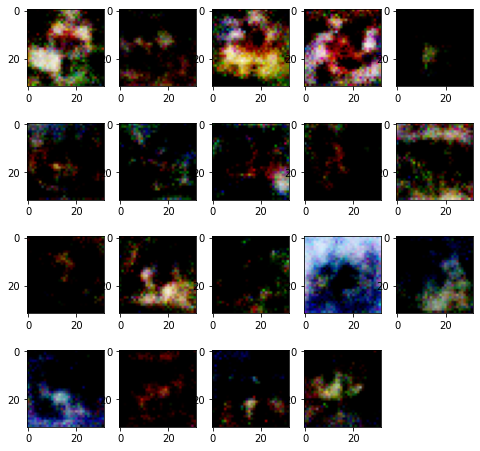

In [8]:
fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
plt.show()

In [11]:
noise = np.random.normal(0, 1, (30,128))
gen_imgs = gan.generator.predict(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

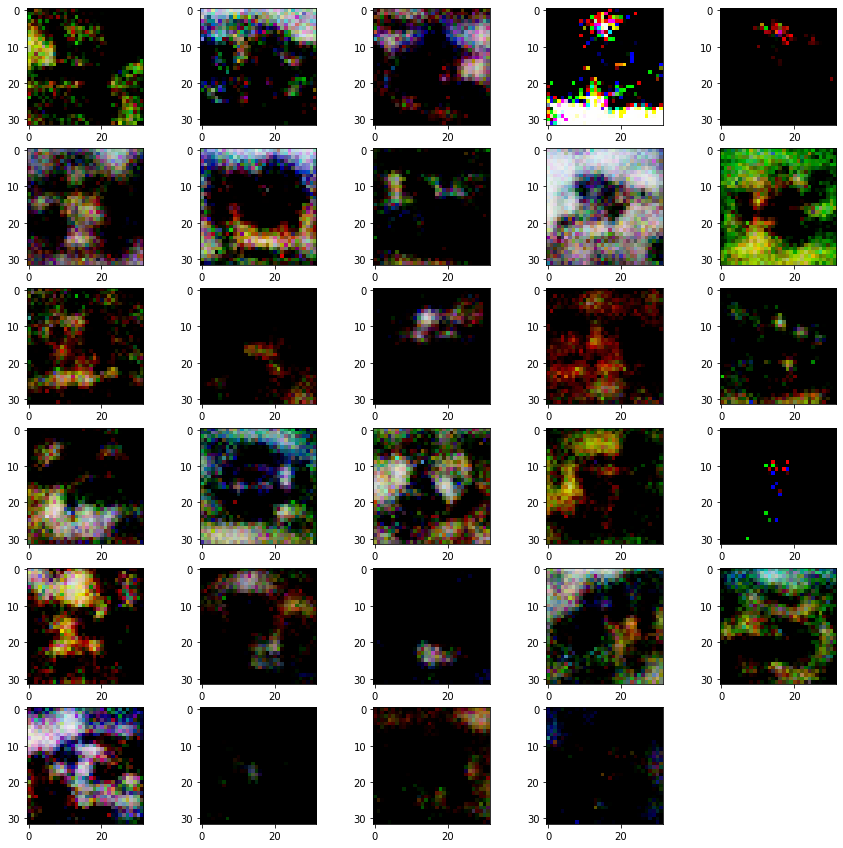

In [12]:
fig = plt.figure(figsize=(15,15))
columns = 5
rows = 6
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
plt.show()